In [1]:
import banditpylib
import numpy as np
import json
import pprint
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
config_file = 'config.json'
# load config file
with open(config_file, 'r') as json_file:
  config = json.load(json_file)

# give each intermediate horizon an independent run
config['running']['horizons'] = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# frequency is useless
config['running']['freq'] = -1

In [3]:
pprint.pprint(config)

{'environment': {'bandit': 'OrdinaryBandit',
                 'params': {'arm': 'BernoulliArm', 'means': [0.3, 0.5, 0.7]}},
 'learners': {'goal': 'regretmin',
              'policies': [{'params': {'name': 'Uniform Sampling',
                                       'type': 'ordinarylearner'},
                            'policy': 'Uniform'},
                           {'params': {'name': 'UCB1',
                                       'type': 'ordinarylearner'},
                            'policy': 'UCB'},
                           {'params': {'type': 'ordinarylearner'},
                            'policy': 'MOSS'},
                           {'params': {'name': 'Thompson Sampling',
                                       'type': 'ordinarylearner'},
                            'policy': 'TS'}]},
 'running': {'freq': -1,
             'horizons': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
             'processors': -1,
             'trials': 200}}


In [4]:
from banditpylib.learners.regretmin import ordinarylearner

In [5]:
# time starts from 1
# arm index starts from 0
# self._t, self._horizon and self._em_arms are inherited from parent class
class ExploreThenCommit(ordinarylearner.OrdinaryLearner):
  
  def __init__(self, pars):
    # call parents' initialization methods
    super().__init__(pars)
    self.__alpha = pars['alpha']

  @property
  def _name(self):
    return 'Explore-Then-Commit'

  def _learner_reset(self):
    # called before the start of the game
    self.__commit = None
    self.__T_zero = self.__alpha*round(self._horizon**(2/3))

  def learner_step(self, context):
    # return the choice at time step self._t
    # context is useless
    del context
    if self._t <= self.__T_zero:
        # pull each arm in a round-robin way
        return (self._t-1) % self._arm_num
    if not self.__commit:
        self.__commit = np.argmax([em_arm.em_mean for em_arm in self._em_arms])
    return self.__commit

  def _learner_update(self, context, action, feedback):
    # called after each time step reward is revealed
    pass

In [6]:
policies = [(ExploreThenCommit, {'alpha': 1.0})]

In [7]:
data = banditpylib.run(config, new_policies=policies)

I0327 12:19:17.204282 4547620288 __init__.py:233] run with goal Regret Minimization
I0327 12:19:17.206894 4547620288 utils.py:126] run Uniform Sampling with protocol SinglePlayerRegretMinProtocol
I0327 12:19:22.332628 4547620288 utils.py:137] 5.12 seconds elapsed
I0327 12:19:22.335222 4547620288 utils.py:126] run UCB1 with protocol SinglePlayerRegretMinProtocol
I0327 12:19:32.376731 4547620288 utils.py:137] 10.04 seconds elapsed
I0327 12:19:32.379504 4547620288 utils.py:126] run MOSS with protocol SinglePlayerRegretMinProtocol
I0327 12:19:43.629157 4547620288 utils.py:137] 11.25 seconds elapsed
I0327 12:19:43.631903 4547620288 utils.py:126] run Thompson Sampling with protocol SinglePlayerRegretMinProtocol
I0327 12:19:55.957448 4547620288 utils.py:137] 12.32 seconds elapsed
I0327 12:19:55.960305 4547620288 utils.py:126] run Explore-Then-Commit with protocol SinglePlayerRegretMinProtocol
I0327 12:20:02.130629 4547620288 utils.py:137] 6.17 seconds elapsed


I0327 12:20:02.291365 4547620288 utils.py:141] NumExpr defaulting to 8 threads.


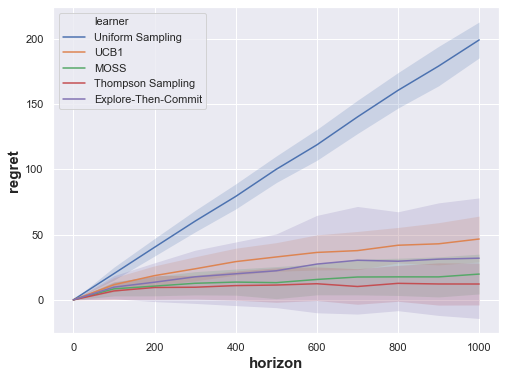

In [8]:
plt.figure(figsize=(8,6))
df = banditpylib.plot(data)